 **Note**: 
This notebook contains code blocks for evaluating the model after hyperparameter tuning using Optuna. The results from these blocks helped guide feature re-engineering and model selection for the ensemble. However, re-running these cells now may not reproduce the same plots or results (saved in the figures folder), since the wrangle() function was improved after each run based on previous outputs.

In [1]:
# Import necessary libraries and modules
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from utils.data_prep import load_and_prepare_data
from utils.pipeline_create import create_pipeline
from utils.model_eval import ModelEvaluator

In [2]:
# Load and prepare the data
data = load_and_prepare_data()

X_train = data['X_train']
X_val = data['X_val1']
y_train = data['y_train']
y_val = data['y_val1']


features = data['features']
linear_features = features['linear']['num'] + features['linear']['cat']
other_features = features['other']['num'] + features['other']['cat']

In [ ]:
# Define model names for reference
model_names = ['ridge', 'lasso', 'elasticnet', 'bayesianridge', 'huberregressor', 
               'randomforest', 'extratrees', 'gradientboosting', 'xgboost', 'lightgbm', 'catboost']

# Corresponding sklearn and boosting model classes
models = [Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor,  
          RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, 
          XGBRegressor, LGBMRegressor, CatBoostRegressor]

# Hyperparameters optimized for each model
params = [
    {'alpha': 0.44, 'solver': 'sag', 'fit_intercept': True, 'tol': 0.00056},
    {'alpha': 0.0001, 'fit_intercept': True, 'tol': 0.00012, 'max_iter': 6191, 'selection': 'cyclic'},
    {'alpha': 0.0001, 'l1_ratio': 0.11, 'fit_intercept': True, 'tol': 0.0022, 'max_iter': 5473, 'selection': 'cyclic'},
    {'alpha_1': 0.00015, 'alpha_2': 0.0257, 'lambda_1': 0.00117, 'lambda_2': 0.0995, 'tol': 0.0037, 'fit_intercept': True, 'compute_score': False},
    {'epsilon': 2.0, 'alpha': 0.00074, 'fit_intercept': True, 'max_iter': 1911, 'tol': 0.022},
    {'n_estimators': 376, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False},
    {'n_estimators': 444, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False},
    {'n_estimators': 492, 'learning_rate': 0.0165, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'subsample': 0.86, 'max_features': None},
    {'n_estimators': 166, 'learning_rate': 0.045, 'max_depth': 8, 'subsample': 1.0, 'colsample_bytree': 0.6, 'reg_alpha': 0.66, 'reg_lambda': 0.0016, 'min_child_weight': 5, 'gamma': 0.19, 'booster': 'gbtree'},
    {'n_estimators': 360, 'learning_rate': 0.069, 'max_depth': 10, 'num_leaves': 80, 'min_child_samples': 39, 'subsample': 0.62, 'colsample_bytree': 0.72, 'reg_alpha': 0.13, 'reg_lambda': 0.34, 'boosting_type': 'gbdt', 'verbose': -1},
    {'bootstrap_type': 'Bayesian', 'iterations': 451, 'learning_rate': 0.11, 'depth': 7, 'l2_leaf_reg': 9.92, 'border_count': 97, 'random_strength': 1.07, 'grow_policy': 'Lossguide', 'bagging_temperature': 0.05, 'verbose': False}
]

In [ ]:
pipeline_dict_1 = {}
# Create pipelines for all models and store in dictionary
for model_name, model, param in zip(model_names, models, params):
    pipeline = create_pipeline(model_name, model, param, features)
    pipeline_dict_1[model_name] = pipeline

model_dict_1 = {}
# Train each pipeline on the training data and save the trained model
for model_name, pipeline in pipeline_dict_1.items():
    pipeline.fit(X_train, y_train)
    model_dict_1[model_name] = pipeline

In [3]:
# Features used by each model type
feature_dict = {
    'ridge': linear_features,
    'lasso': linear_features,
    'elasticnet': linear_features,
    'bayesianridge': linear_features,
    'huberregressor': linear_features,
    'randomforest': other_features,
    'extratrees': other_features,
    'gradientboosting': other_features,
    'xgboost': other_features,
    'lightgbm': other_features,
    'catboost': other_features
}

In [ ]:
# Initialize evaluator with models and validation data
evaluator = ModelEvaluator(model_dict_1, X_val, y_val, feature_dict)
# Evaluate models on data segments
segment_df = evaluator.segment_evaluation()
permutation_importance = evaluator.permutation_importance()
evaluation_df, residual_comparison, error_correlation = evaluator.error_analysis()

This round of model evaluation led to a lot of useful conclusions. Among the linear models, Ridge Regression performed slightly better than the others and was selected for the ensemble. I chose to include one linear model because it gives a different perspective on the target variable compared to tree-based models.

When it came to tree-based models — which mostly relied on the newly engineered features — I picked ExtraTrees because its errors were less correlated with the boosted models like LightGBM, CatBoost, and XGBoost. This helps add diversity to the stack, which is important for better generalization.

The validation set performance for each model is shown in the table below.
| Model      | RMSE     | MAE      | R²       |
|------------|----------|----------|----------|
| Ridge      | 0.17105  | 0.12848  | 0.96819  |
| ExtraTrees | 0.06132  | 0.03477  | 0.99591  |
| XGBoost    | 0.06101  | 0.03488  | 0.99595  |
| LightGBM   | 0.06035  | 0.03440  | 0.99604  |
| CatBoost   | 0.06131  | 0.03542  | 0.99591  |

After the second round of feature engineering and Optuna tuning, all selected models showed improvement in performance. Ridge Regression, in particular, benefited significantly from the newly engineered features, and the tree-based models also showed subtle but meaningful improvements. The updated validation set metrics are shown below:
| Model      | RMSE     | MAE      | R²       |
|------------|----------|----------|----------|
| Ridge      | 0.10473  | 0.07373  | 0.98808  |
| ExtraTrees | 0.06087  | 0.03406  | 0.99599  |
| XGBoost    | 0.06038  | 0.03463  | 0.99604  |
| LightGBM   | 0.06035  | 0.03426  | 0.99604  |
| CatBoost   | 0.06157  | 0.03476  | 0.99599  |

After residual analysis and hyperparameter tuning, I got a better set of hyperparameters for all models. Now I’m running model evaluation (using the ModelEvaluator class) on all of them to see how they perform on the validation set.

In [5]:
model_name = ['ridge', 'extratrees', 'xgboost', 'lightgbm', 'catboost']

models = [Ridge, ExtraTreesRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor]

params = [{'alpha': 0.3744806562337833, 'solver': 'sag', 'fit_intercept': True, 'tol': 0.0007622314553132402},
          {'n_estimators': 326, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False},
          {'n_estimators': 683, 'learning_rate': 0.05710400944032593, 'max_depth': 7, 'subsample': 0.8708501983892822, 'colsample_bytree': 0.5990353703327878, 'reg_alpha': 3.254066913534751, 'reg_lambda': 0.01593621652838458, 'min_child_weight': 2, 'gamma': 0.0009536580000644827, 'booster': 'gbtree'},
          {'max_depth': 12, 'num_leaves': 99, 'n_estimators': 491, 'learning_rate': 0.05954360974397409, 'min_child_samples': 21, 'subsample': 0.5066852407414704, 'colsample_bytree': 0.8619994805735846, 'reg_alpha': 3.595735178870403, 'reg_lambda': 1.24462626575653, 'verbose': -1},
          {'bootstrap_type': 'Bernoulli', 'iterations': 406, 'learning_rate': 0.028763633853386924, 'depth': 10, 'l2_leaf_reg': 11.869905054427921, 'border_count': 125, 'random_strength': 7.610826130799793, 'grow_policy': 'Depthwise', 'verbose': False}]

pipeline_dict_2 = {}

for model_name, model, param in zip(model_name, models, params):
    pipeline = create_pipeline(model_name, model, param, features)
    pipeline_dict_2[model_name] = pipeline  

model_dict_2 = {}

for model_name, pipeline in pipeline_dict_2.items():
    pipeline.fit(X_train, y_train)
    model_dict_2[model_name] = pipeline

evaluator_2 = ModelEvaluator(model_dict_2, X_val, y_val, feature_dict)

In [6]:
segment_df_2 = evaluator_2.segment_evaluation()
segment_df_2

,model,segment_no,rmse,mae,r2
0,ridge,0,0.115953,0.077960,0.970560
1,extratrees,0,0.093345,0.056568,0.980921
2,xgboost,0,0.092597,0.056757,0.981226
3,lightgbm,0,0.092543,0.056762,0.981247
4,catboost,0,0.093931,0.058637,0.980680
5,ridge,1,0.054896,0.041554,0.949596
6,extratrees,1,0.037702,0.026178,0.976225
7,xgboost,1,0.037826,0.026152,0.976068
8,lightgbm,1,0.037810,0.026071,0.976089
9,catboost,1,0.038703,0.027131,0.974946


In [7]:
permutation_importance_2 = evaluator_2.permutation_importance()
permutation_importance_2

,sex,age,height,weight,duration,heart_rate,body_temp,bmi,temp_deviation,cardio_load,...,hr_per_minute,temp_duration_product,age_cardio_load,row_mean,row_std,log_age_cardio_load,log_weight_duration_ratio,temp_duration_product_bin,temp_hr_ratio_bin,age_bin
model,,,,,,,,,,,,,,,,,,,,,
ridge,0.098953,0.002425,NaN,0.000097,NaN,NaN,NaN,0.000000,0.005703,0.000000,...,0.000000,0.002264,0.000007,0.015804,0.057240,0.103412,0.004500,0.715082,0.124432,0.041902
extratrees,0.007400,0.007641,0.065731,0.000028,0.000909,3.879825e-07,0.037650,0.000029,0.025228,0.006837,...,0.002409,0.018270,0.000705,0.000206,0.001761,0.008485,0.002491,NaN,NaN,NaN
xgboost,0.001206,0.010304,0.247023,0.000019,0.000501,1.267024e-05,0.015598,0.000023,0.062223,0.041609,...,0.000987,0.014767,0.000451,0.000508,0.002544,0.013119,0.000058,NaN,NaN,NaN
lightgbm,0.000253,0.010568,1.038920,0.000010,0.002426,2.312131e-05,0.000765,0.000010,0.002350,0.029527,...,0.002168,0.024079,0.000468,0.000754,0.010709,0.002755,0.000027,NaN,NaN,NaN
catboost,0.027673,0.009725,0.144492,0.000366,0.003392,1.040693e-04,0.083916,0.000154,0.072096,0.009153,...,0.012737,0.036467,0.001408,0.003943,0.028936,0.009960,0.018084,NaN,NaN,NaN


,model,rmse,mae,r2
0,ridge,0.079945,0.052460,0.993065
1,extratrees,0.060797,0.034200,0.995989
2,xgboost,0.060367,0.034323,0.996046
3,lightgbm,0.060297,0.034253,0.996055
4,catboost,0.061450,0.035616,0.995902


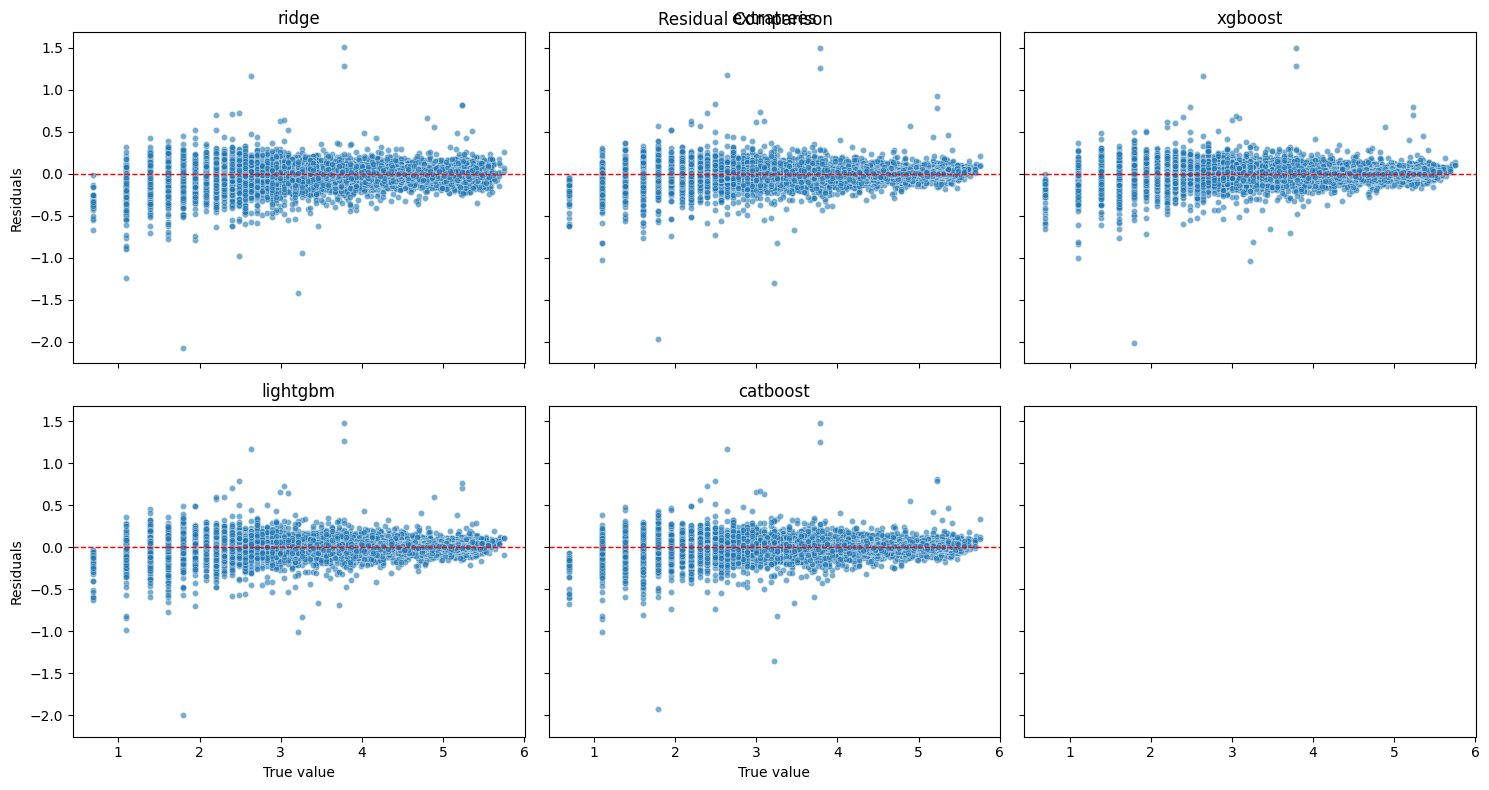

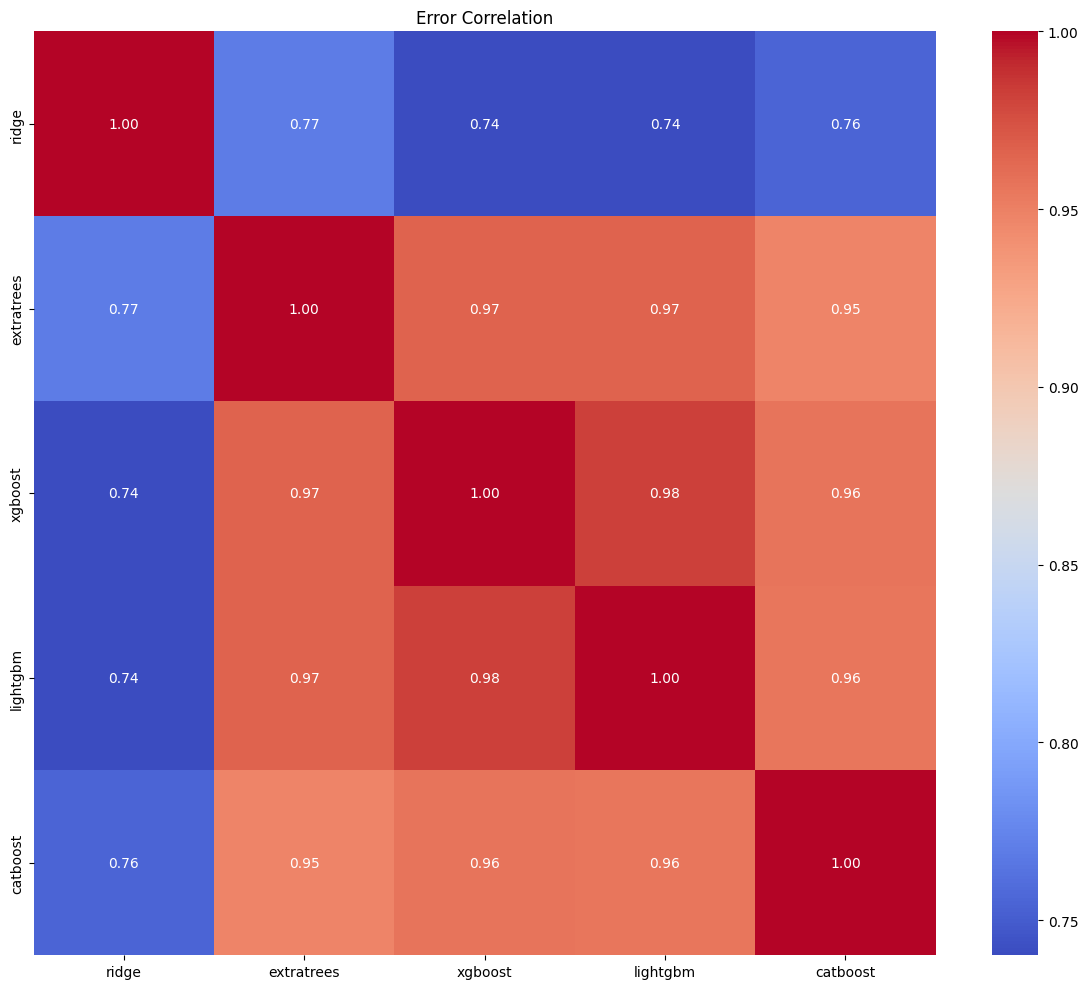

In [8]:
evaluation_df_2, residual_comparison_2, error_correlation_2 = evaluator_2.error_analysis()
evaluation_df_2